# Anomaly Detection 

This notebook attempts anomaly detection using the time series trend of traffic data. 

Current scope:
- Use only the total number of cars on the road
- Not taking into account:
    - Traffic direction 
    - Position of cars

## Packages

In [1]:
import os 
import pickle 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
from datetime import timedelta

# Import project packages
from anomaly_detection.models import AverageModel, ResettablePipeline
from anomaly_detection.preprocess import ImputeVals
from anomaly_detection.plotting import ForecastAllDayPlotter, ForecastPerWeekdayPlotter

## Constants

In [2]:
SEED=53456
CAMERA = '147'
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sample_period = '30min' #period to temporally aggregate the data
thresh_samples = 350 #minimum number of samples to consider a day

# setting up the paths
# data paths
cwd=os.getcwd()
root = os.path.dirname(cwd)
processed_image_dir = os.path.join(root, 'dat','processed_images')
image_folder = os.path.join(processed_image_dir,CAMERA,'2024-12-11')
output_folder = os.path.join(root, 'dat','output')
camera_dir = os.path.join(processed_image_dir, CAMERA)
tabular_csv_path = os.path.join(output_folder, 'traffic_147_two_way.csv')
plot_csv_path = os.path.join(output_folder, 'plot_traffic_147.csv')
html_path = os.path.join(root, 'index.html')
# model paths
run_dir = os.path.join(root, 'runs','detect')
best_weights_path  = os.path.join(run_dir, 'train15', 'weights','best.pt')
time_series_model_dir = os.path.join(root, 'dat', 'model', 'time_series_model')
average_model_path = os.path.join(time_series_model_dir, 'average_model.pkl')
os.makedirs(time_series_model_dir, exist_ok=True)

## Functions

In [3]:
get_30min = lambda x: (x.hour*60 + x.minute)//30

## Loading data

In [4]:
df = pd.read_csv(tabular_csv_path)
df['time'] = pd.to_datetime(df['time'])

## Preprocessing

Filtering samples
- Filtering outdays with sample below `thresh_samples` set in constants.

Plotting trends
- The samples at two minute level resolution is noisy. Therefore, temporal aggregation is required.
- Interpolation is required for some day above the `thresh_samples` due to missing values

Aggregating data
- The sample have been aggregated temporally at 30 minute intervals. 
- When plotting the trends are cleaner and can be used for modelling/anomaly detection.

Interpolating values 
- Average values have been calculated by grouping by day and time of day.
- Missing values are filled using the averages calculated above. 

<a id="filter_samples"></a>
### Filtering samples

In [5]:
df['time'] = pd.to_datetime(df['time'])
df.sort_values(by='time', inplace=True)
df['day_of_year'] = df['time'].dt.dayofyear + (df['time'].dt.year-2024)*365
df['day'] = df['time'].dt.day_of_week
df['30min'] = df['time'].map(get_30min)
series_n_samples = df['day_of_year'].value_counts()

valid_days = series_n_samples[series_n_samples>thresh_samples].index
mask = df.day_of_year.map(lambda x: x in valid_days)
df_filtered = df[mask].reset_index(drop=True)

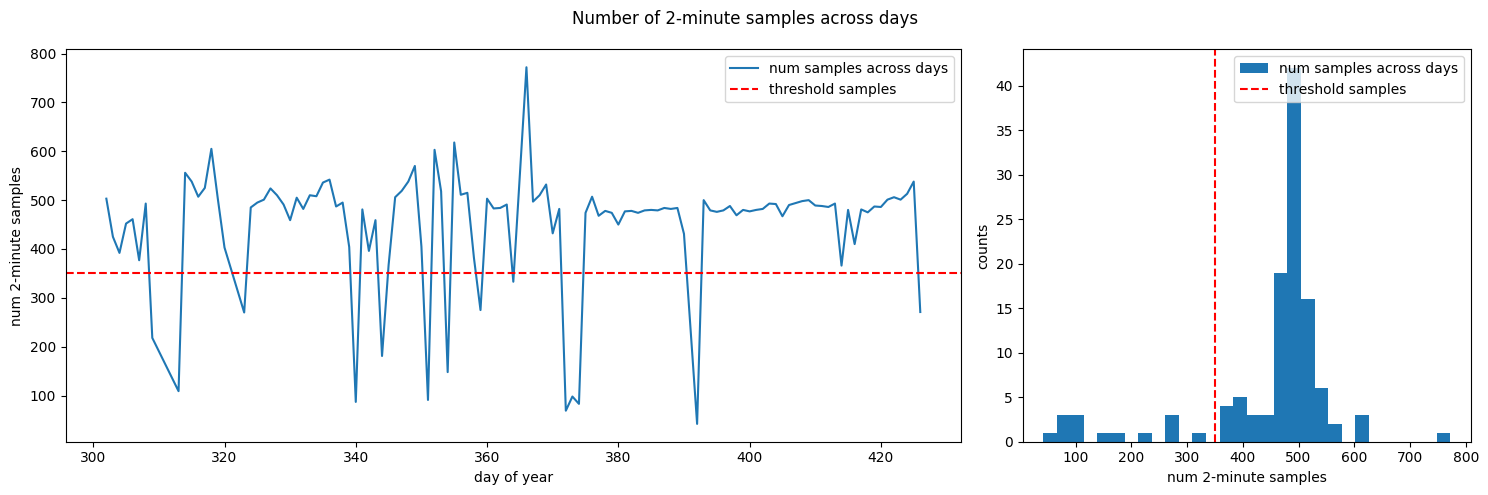

In [6]:
figure_size = (15, 5)

fig = plt.figure(figsize=figure_size)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # Adjust the width ratios

# Line plot
ax0 = plt.subplot(gs[0])


series_n_samples.sort_index().plot(kind='line', ax=ax0, label='num samples across days')
ax0.axhline(y=thresh_samples, color='r', linestyle='--', label='threshold samples')
ax0.set_xlabel('day of year')
ax0.set_ylabel('num 2-minute samples')
ax0.legend()

# Histogram
ax1 = plt.subplot(gs[1])
series_n_samples.plot(kind='hist', ax=ax1, bins=30, label='num samples across days')
ax1.axvline(x=thresh_samples, color='r', linestyle='--', label='threshold samples')
ax1.set_xlabel('num 2-minute samples')
ax1.set_ylabel('counts')
ax1.legend()

plt.suptitle('Number of 2-minute samples across days')
plt.tight_layout()
plt.show()

### Plotting trends

In [7]:
filter_date = lambda start_date, end_date: df_filtered.query(f"time >= '{start_date}' and time <= '{end_date}'")

def plot_days(start_date, end_date, figure_size=figure_size):
    df_plot = filter_date(start_date, end_date)
    plt.figure(figsize=figure_size)
    plt.plot(df_plot['time'], df_plot['num_cars'])
    plt.xlabel('time')
    plt.ylabel('num cars')
    plt.xticks(rotation=45)
    plt.show()


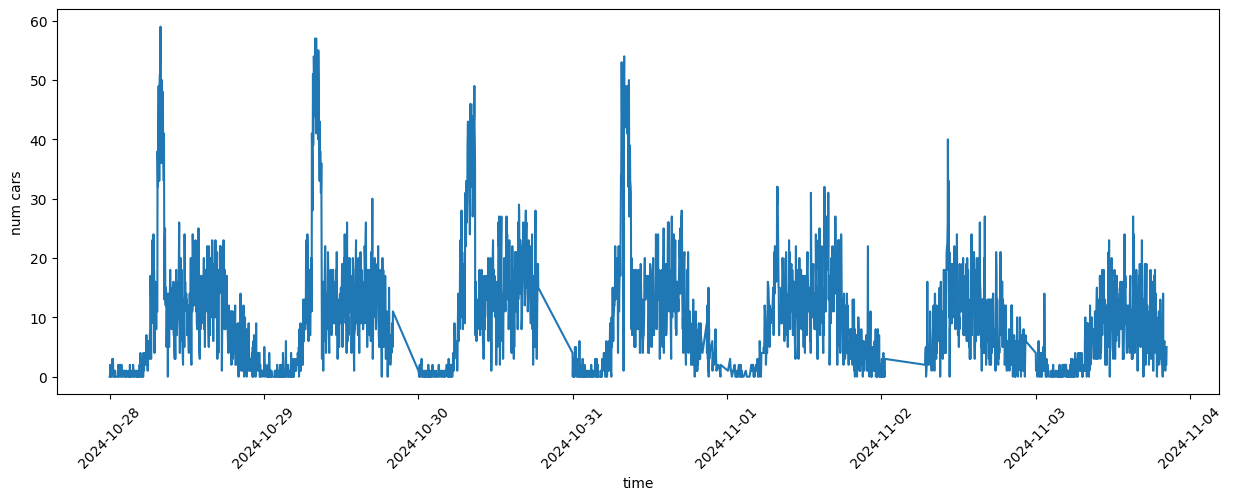

In [8]:
start_date = "2024-10-28"
end_date = "2024-11-04"
plot_days(start_date, end_date)

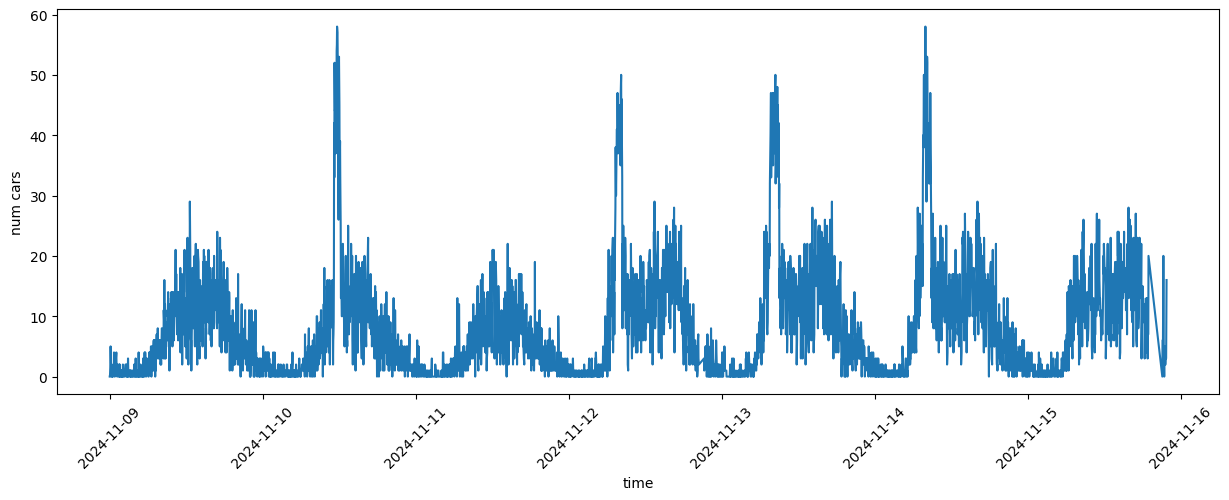

In [9]:
start_date = "2024-11-05"
end_date = "2024-11-16"
plot_days(start_date, end_date)

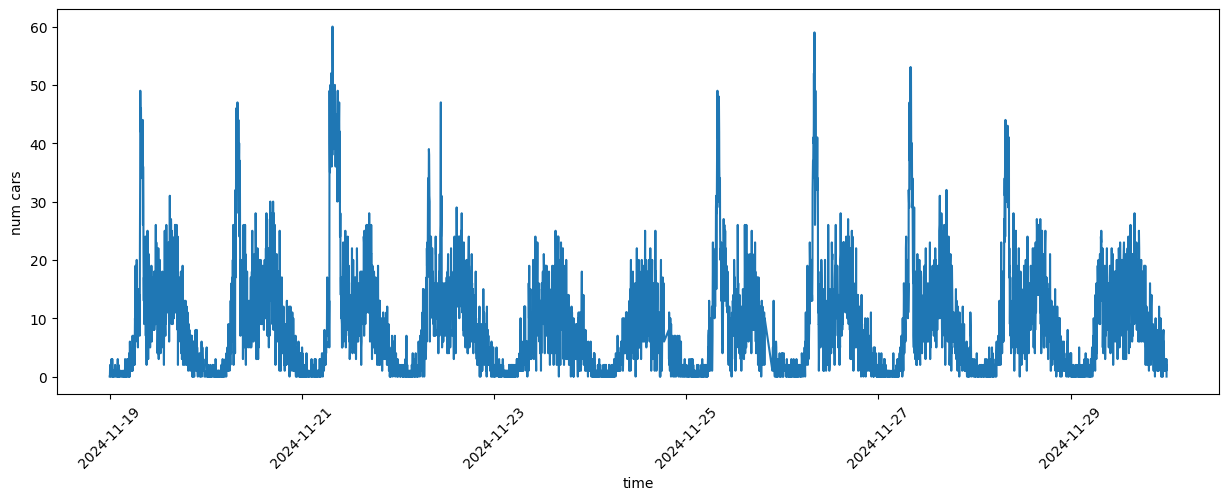

In [10]:
start_date = "2024-11-16"
end_date = "2024-11-30"
plot_days(start_date, end_date)

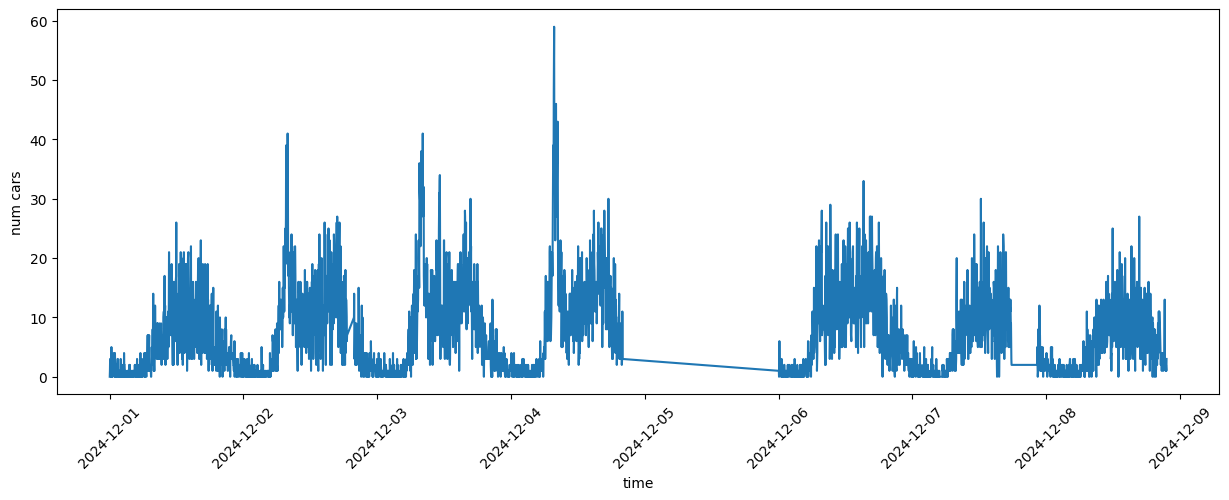

In [11]:
start_date = "2024-12-1"
end_date = "2024-12-9"
plot_days(start_date, end_date)

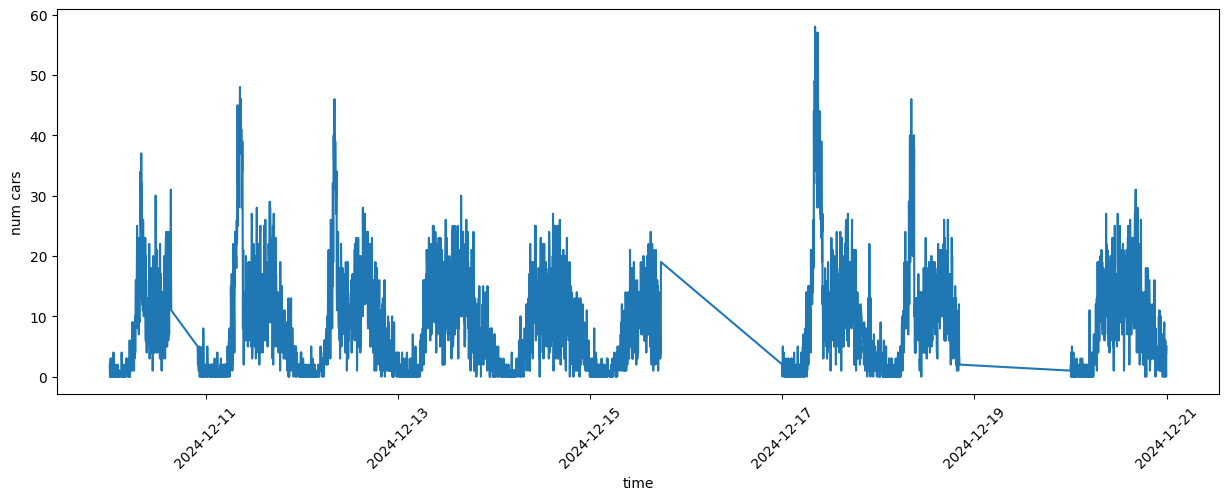

In [12]:
start_date = "2024-12-9"
end_date = "2024-12-21"
plot_days(start_date, end_date)

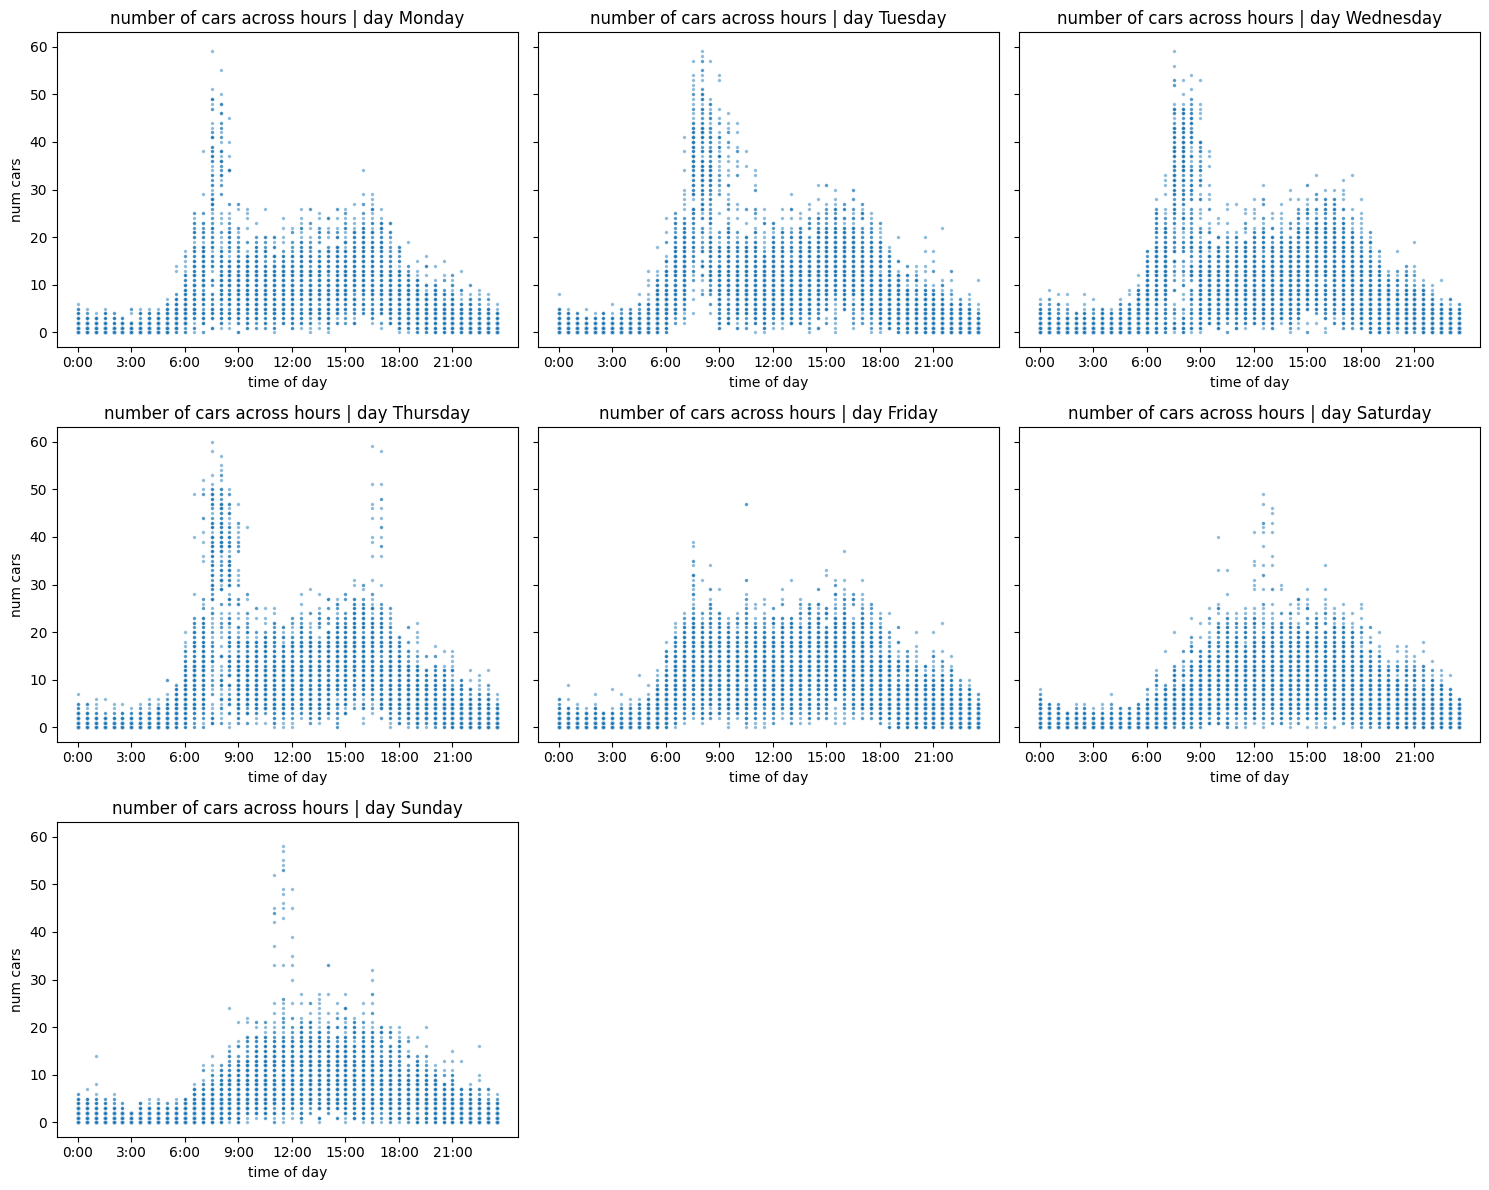

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=False, sharey=True)
x_loc = np.arange(0, 48, 6)
x_labels = [f'{i//2}:00' if i%2==0 else f'{i//2}:30' for i in x_loc]

axes = axes.flatten()
for i, day in enumerate(range(7)):
    ax = axes[day]
    sns.scatterplot(data=df_filtered.query(f"day == {day}"), x='30min', y='num_cars', s=6, alpha=0.5, ax=ax)
    ax.set_xticks(x_loc, x_labels, rotation=0)
    ax.set_xlabel('time of day')
    ax.set_ylabel('num cars')
    ax.set_title(f'number of cars across hours | day {days[day]}')

# Remove the unused axis
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Temporal aggregation 

In [14]:
index_name = 'time'

# Aggregating the data temporally 
df_agg = df_filtered.copy()
df_agg.set_index(index_name, inplace=True)
df_agg = df_agg[['num_cars', 'incoming', 'outgoing']].resample(sample_period).mean()
full_index = pd.date_range(
    start=df_agg.index.min().replace(hour=0, minute=0, second=0),
    end=df_agg.index.max().replace(hour=23, minute=30, second=0),
    freq=sample_period
)
df_agg = df_agg.reindex(full_index)
df_agg.index.name = index_name


# Recomputing columns resampled dataframe
df_agg['day_of_year']=df_agg.index.map(lambda x: x.day_of_year).values
df_agg['day']=df_agg.index.map(lambda x: x.day_of_week).values
df_agg['time_of_day'] = df_agg.index.time
df_agg['30min']=df_agg['time_of_day'].apply(get_30min)

# Remove days with no samples
series_day_cars = df_agg.groupby('day_of_year')['num_cars'].count()
filter_days = series_day_cars[series_day_cars==0]
df_agg = df_agg[~df_agg['day_of_year'].map(lambda x: x in filter_days.index)]

In [15]:
df_agg.index.day_of_week.values

array([0, 0, 0, ..., 5, 5, 5])

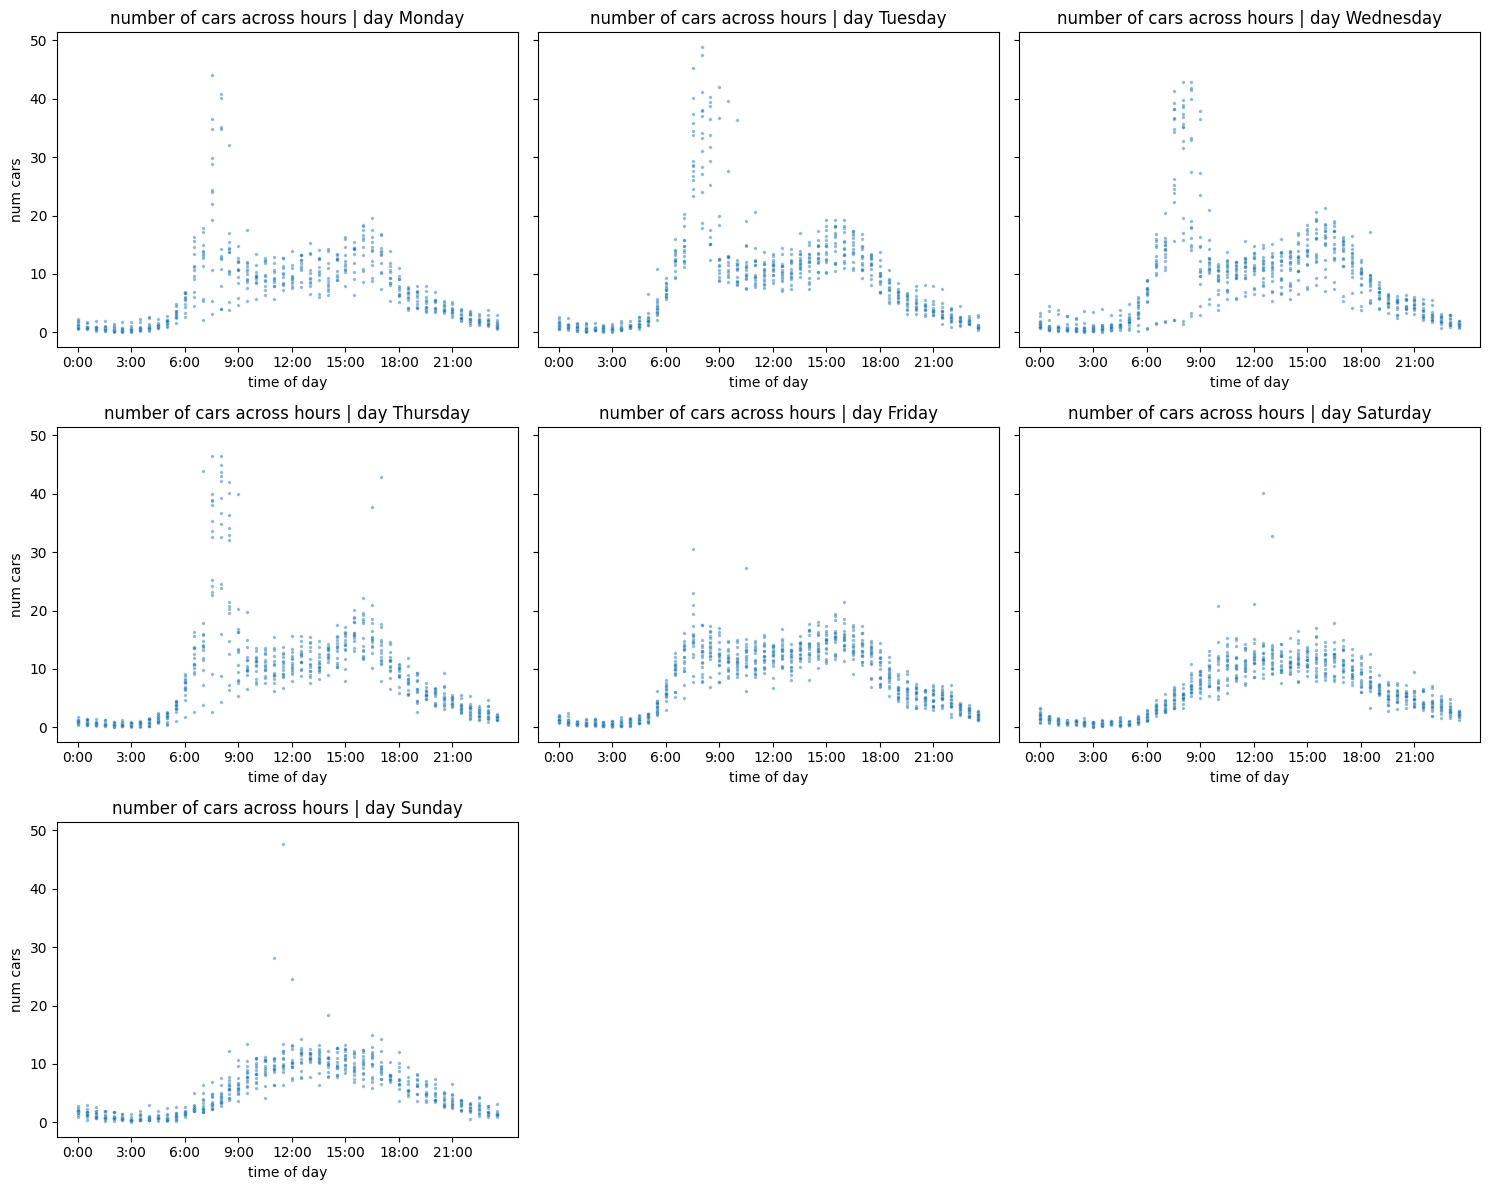

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=False, sharey=True)
x_loc = np.arange(0, 48, 6)
x_labels = [f'{i//2}:00' if i%2==0 else f'{i//2}:30' for i in x_loc]

axes = axes.flatten()
for i, day in enumerate(range(7)):
    ax = axes[day]
    sns.scatterplot(data=df_agg.query(f"day == {day}"), x='30min', y='num_cars', s=6, alpha=0.5, ax=ax)
    ax.set_xticks(x_loc, x_labels, rotation=0)
    ax.set_xlabel('time of day')
    ax.set_ylabel('num cars')
    ax.set_title(f'number of cars across hours | day {days[day]}')

# Remove the unused axis
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Histogram of num cars')

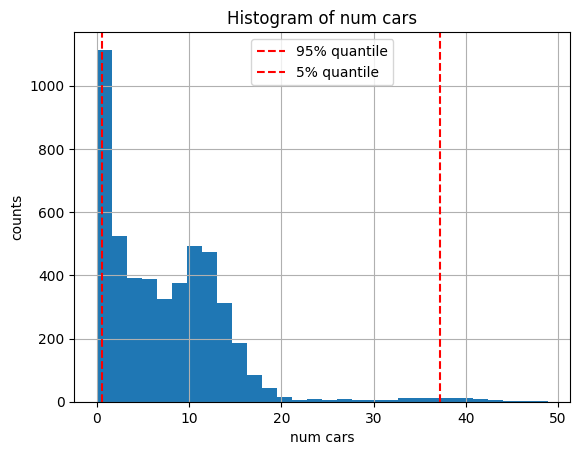

In [17]:
df_agg['num_cars'].hist(bins=30)
vmax = df_agg['num_cars'].quantile(0.99)
vmin = df_agg['num_cars'].quantile(0.05)

plt.axvline(x=vmax, color='r', linestyle='--', label='95% quantile')
plt.axvline(x=vmin, color='r', linestyle='--', label='5% quantile')
plt.xlabel('num cars')
plt.ylabel('counts')
plt.legend()
plt.title('Histogram of num cars')

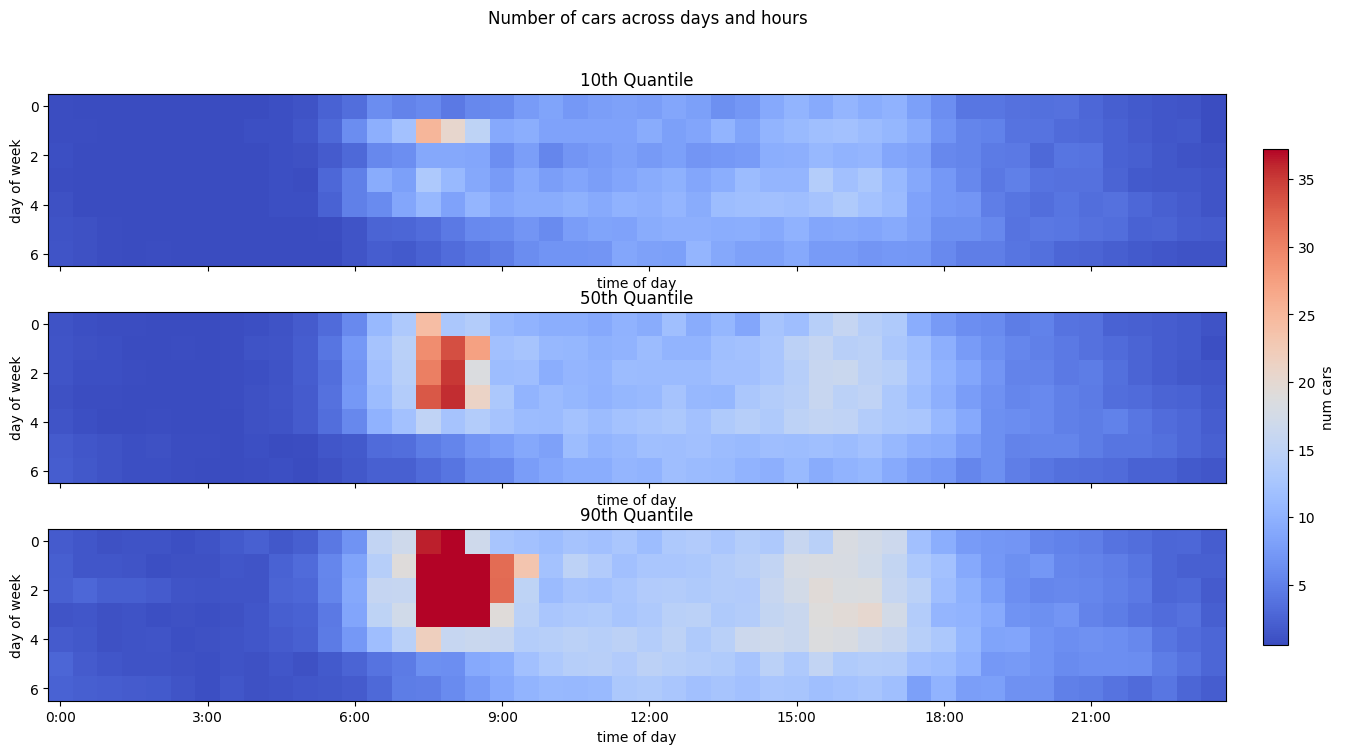

In [18]:

fig, axes = plt.subplots(3, 1, figsize=(16, 8), sharex=True, sharey=True)

quantiles = [0.10, 0.50, 0.90]
titles = ['10th Quantile', '50th Quantile', '90th Quantile']

plt.suptitle('Number of cars across days and hours')

for ax, quantile, title in zip(axes, quantiles, titles):
    matrix = df_agg.groupby(['time_of_day', 'day'])['num_cars'].quantile(quantile).unstack()
    im = ax.imshow(matrix.values.T, cmap='coolwarm', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_ylabel('day of week')
    ax.set_xlabel('time of day')
    ax.set_xticks(x_loc)
    ax.set_xticklabels(x_labels, rotation=0)

#fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
fig.colorbar(im, ax=axes, label='num cars',fraction=0.02, pad=0.03)
plt.show()

### Removing anomalies

For now anomalies are removed manually. Once the model is trained anomalies can be removed automatically. 

In [19]:
#TODO: move remove_days to the constants at the top
remove_days = [316, 315]
mask = df_agg.day_of_year.map(lambda x: x not in remove_days)
df_agg = df_agg.loc[mask,:].copy()

In [20]:
df_agg

num_cars  incoming  outgoing  day_of_year  day  \
time                                                                  
2024-10-28 00:00:00  0.727273  0.181818  0.545455          302    0   
2024-10-28 00:30:00  0.545455  0.000000  0.545455          302    0   
2024-10-28 01:00:00  0.200000  0.000000  0.200000          302    0   
2024-10-28 01:30:00  0.727273  0.272727  0.454545          302    0   
2024-10-28 02:00:00  0.500000  0.300000  0.200000          302    0   
...                       ...       ...       ...          ...  ...   
2025-03-01 21:30:00  6.166667  2.500000  3.666667           60    5   
2025-03-01 22:00:00  4.363636  2.545455  1.818182           60    5   
2025-03-01 22:30:00  2.363636  1.727273  0.636364           60    5   
2025-03-01 23:00:00  1.916667  0.833333  1.083333           60    5   
2025-03-01 23:30:00  2.727273  1.545455  1.181818           60    5   

                    time_of_day  30min  
time                                    
2024-10-28 00:00:00    00:00:00      0  
2024-10-28 00:30:00    00:30:00      1  
2024-10-28 01:00:00    01:00:00      2  
2024-10-28 01:30:00    01:30:00      3  
2024-10-28 02:00:00    02:00:00      4  
...                         ...    ...  
2025-03-01 21:30:00    21:30:00     43  
2025-03-01 22:00:00    22:00:00     44  
2025-03-01 22:30:00    22:30:00     45  
2025-03-01 23:00:00    23:00:00     46  
2025-03-01 23:30:00    23:30:00     47  

[4944 rows x 7 columns]

### Splitting the data

In [21]:
df_agg.head()

num_cars  incoming  outgoing  day_of_year  day  \
time                                                                  
2024-10-28 00:00:00  0.727273  0.181818  0.545455          302    0   
2024-10-28 00:30:00  0.545455  0.000000  0.545455          302    0   
2024-10-28 01:00:00  0.200000  0.000000  0.200000          302    0   
2024-10-28 01:30:00  0.727273  0.272727  0.454545          302    0   
2024-10-28 02:00:00  0.500000  0.300000  0.200000          302    0   

                    time_of_day  30min  
time                                    
2024-10-28 00:00:00    00:00:00      0  
2024-10-28 00:30:00    00:30:00      1  
2024-10-28 01:00:00    01:00:00      2  
2024-10-28 01:30:00    01:30:00      3  
2024-10-28 02:00:00    02:00:00      4

In [22]:
df_train = df_agg.query('time < "2024-12-21"').copy()
df_test = df_agg.query('time >= "2024-12-21"').copy()

### Interpolating values 

In [23]:
imputer = ImputeVals(m=48)
X = df_train[['num_cars', 'day']].values
X_out = imputer.fit_transform(X)
df_train['filled_num_cars'] = X_out[:,0]

In [24]:
X = df_test[['num_cars', 'day']].values
X_out = imputer.transform(X)
df_test['filled_num_cars'] = X_out[:,0]

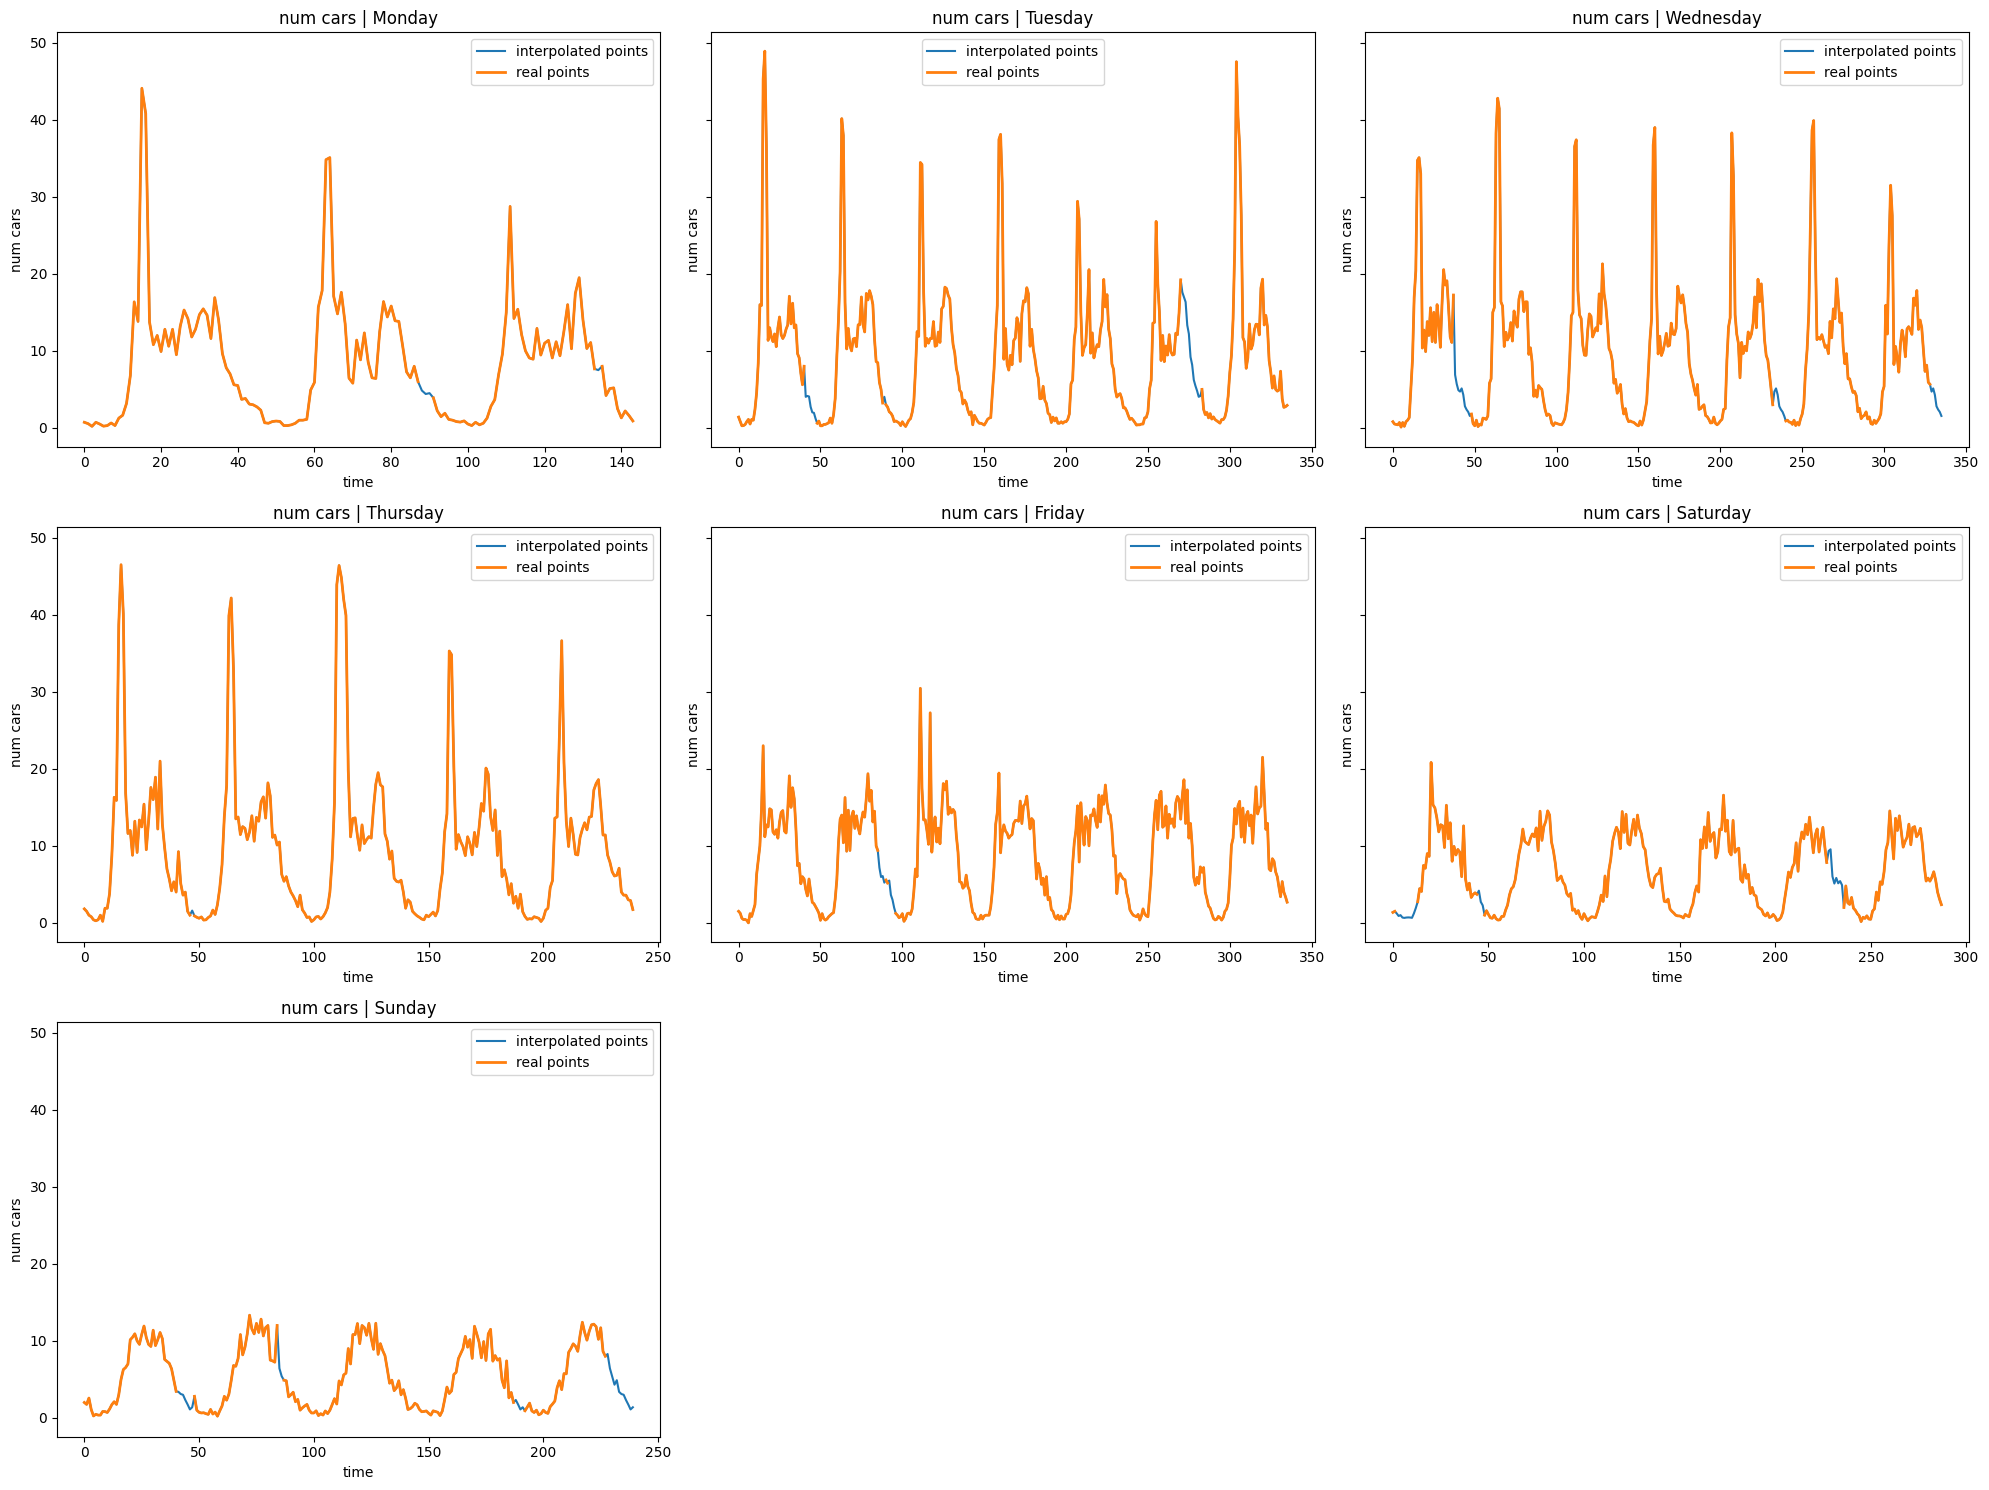

In [25]:
df_check = df_train
fig, axes = plt.subplots(3, 3, figsize=(20, 15), sharex=False, sharey=True)
axes = axes.flatten()
for i, day in enumerate(range(7)):
    ax = axes[i]
    df_plot = df_check.query(f"day == {day}")
    ax.plot(np.arange(len(df_plot)),df_plot['filled_num_cars'], label='interpolated points')
    ax.plot(np.arange(len(df_plot)),df_plot['num_cars'], label='real points', lw=2)
    ax.set_title(f'num cars | {days[day]}')
    ax.set_xlabel('time')
    ax.set_ylabel('num cars')
    ax.legend()

# Remove the unused axis
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()

## Modelling

### Training 

In [26]:
pipeline = ResettablePipeline([
    ('imputer', ImputeVals(m=48)),
    ('model', AverageModel(m=48, window_size=2, error_tol=5))
])

X_train = df_train[['num_cars', 'day']].values
train_dates = [time.strftime('%Y-%m-%d') for time in df_train.index]
pipeline.fit(X_train)
forecast_train = pipeline.predict(X_train)
pickle.dump(pipeline, open(average_model_path, 'wb'))

### Prediction

In [27]:
X_test = df_test[['num_cars', 'day',]].values
test_dates = [time.strftime('%Y-%m-%d') for time in df_test.index]
forecast_test = pipeline.predict(X_test)

### Plots across each week day

#### Monday

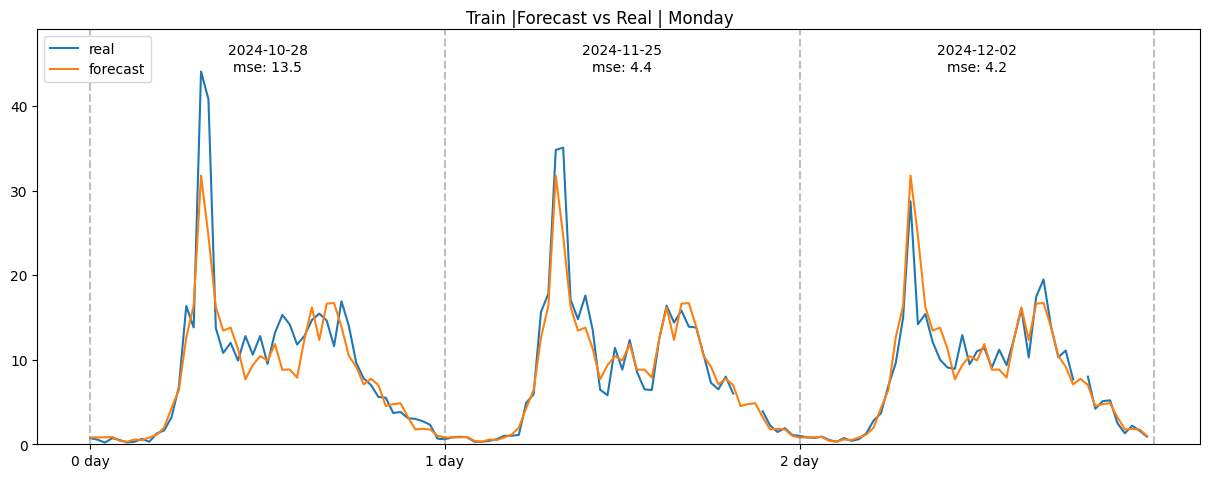

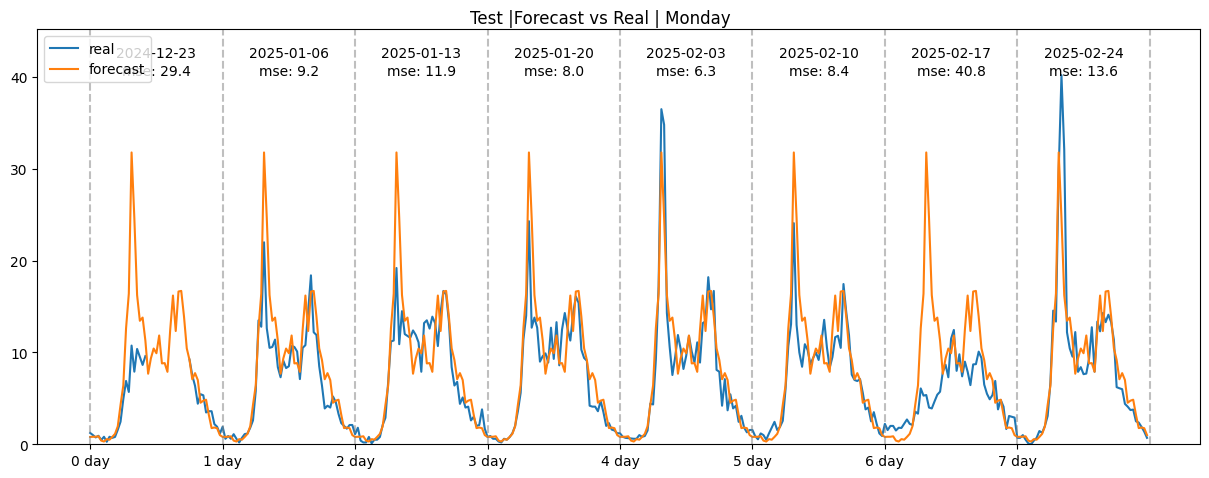

In [28]:
day=0
fig = ForecastPerWeekdayPlotter(day=day).plot(X_train, forecast_train, train_dates)
fig.suptitle(f'Train |Forecast vs Real | {days[day]}')
fig = ForecastPerWeekdayPlotter(day=day).plot(X_test, forecast_test, test_dates)
fig.suptitle(f'Test |Forecast vs Real | {days[day]}')
plt.show()

#### Tuesday 

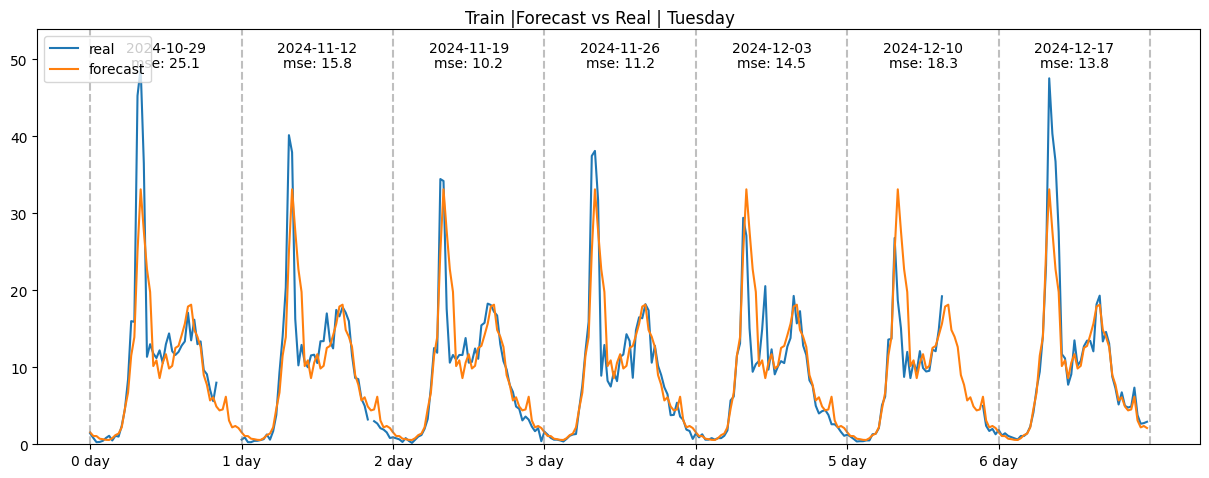

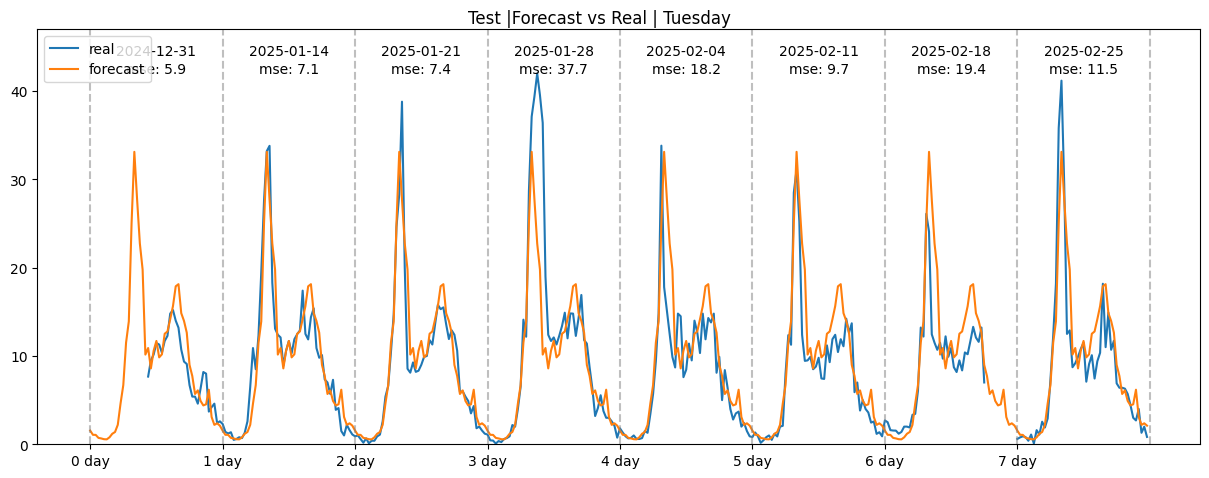

In [29]:
day=1
fig = ForecastPerWeekdayPlotter(day=day).plot(X_train, forecast_train, train_dates)
fig.suptitle(f'Train |Forecast vs Real | {days[day]}')
fig = ForecastPerWeekdayPlotter(day=day).plot(X_test, forecast_test, test_dates)
fig.suptitle(f'Test |Forecast vs Real | {days[day]}')
plt.show()

#### Wednesday

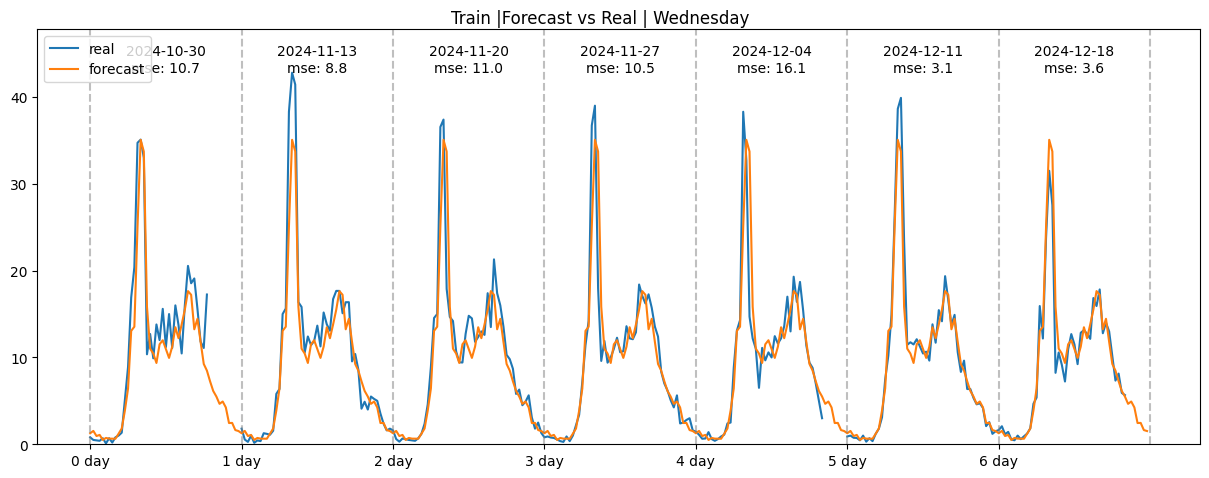

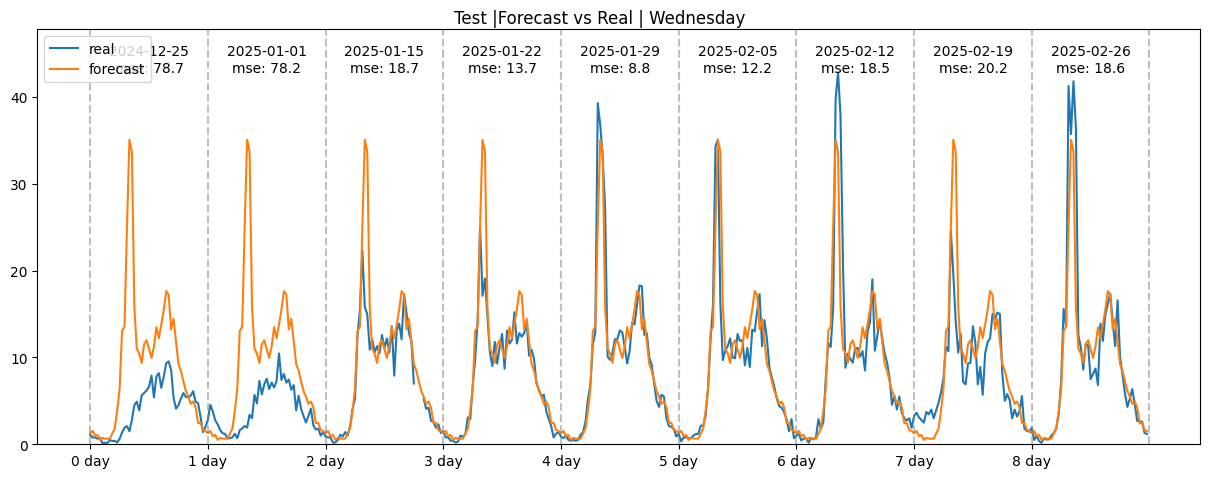

In [30]:
day=2
fig = ForecastPerWeekdayPlotter(day=day).plot(X_train, forecast_train, train_dates)
fig.suptitle(f'Train |Forecast vs Real | {days[day]}')
fig = ForecastPerWeekdayPlotter(day=day).plot(X_test, forecast_test, test_dates)
fig.suptitle(f'Test |Forecast vs Real | {days[day]}')
plt.show()

#### Thursday

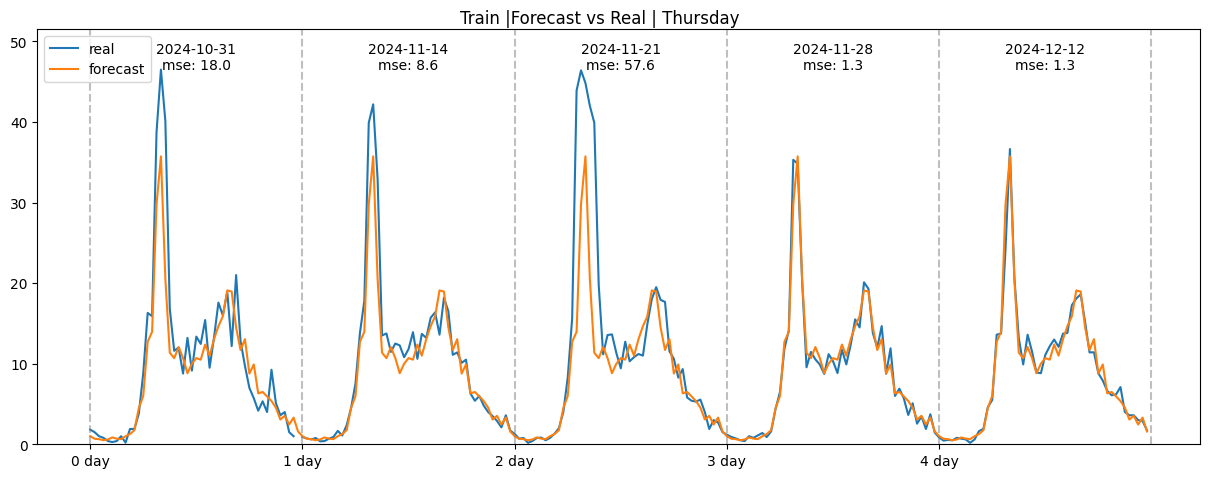

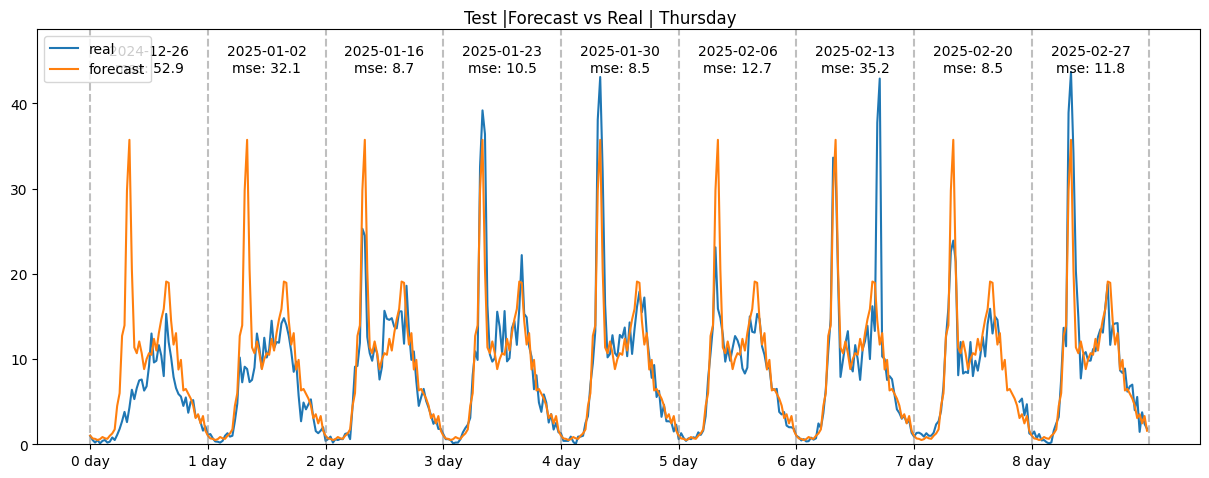

In [31]:
day=3
fig = ForecastPerWeekdayPlotter(day=day).plot(X_train, forecast_train, train_dates)
fig.suptitle(f'Train |Forecast vs Real | {days[day]}')
fig = ForecastPerWeekdayPlotter(day=day).plot(X_test, forecast_test, test_dates)
fig.suptitle(f'Test |Forecast vs Real | {days[day]}')
plt.show()

#### Friday

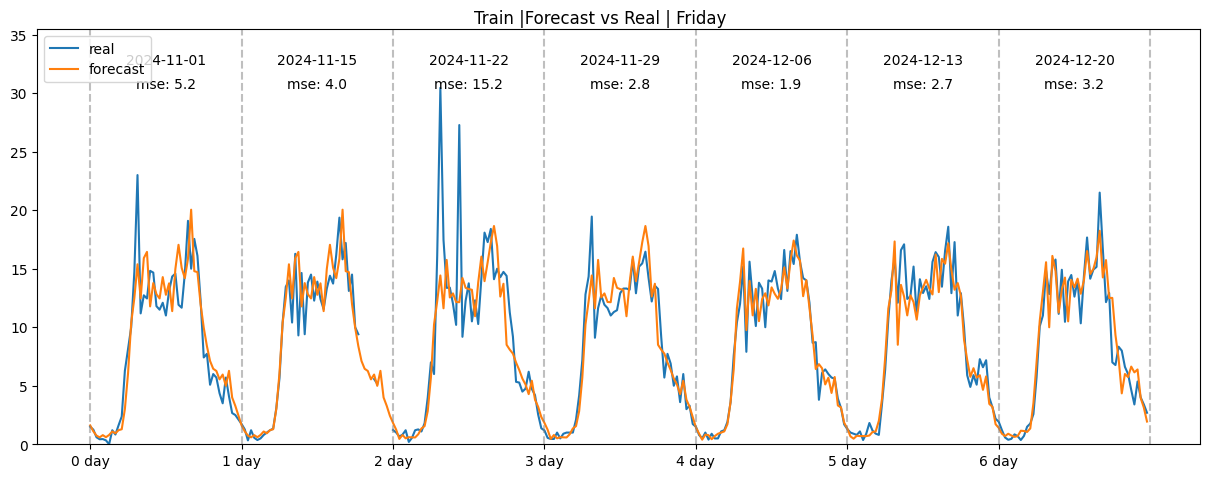

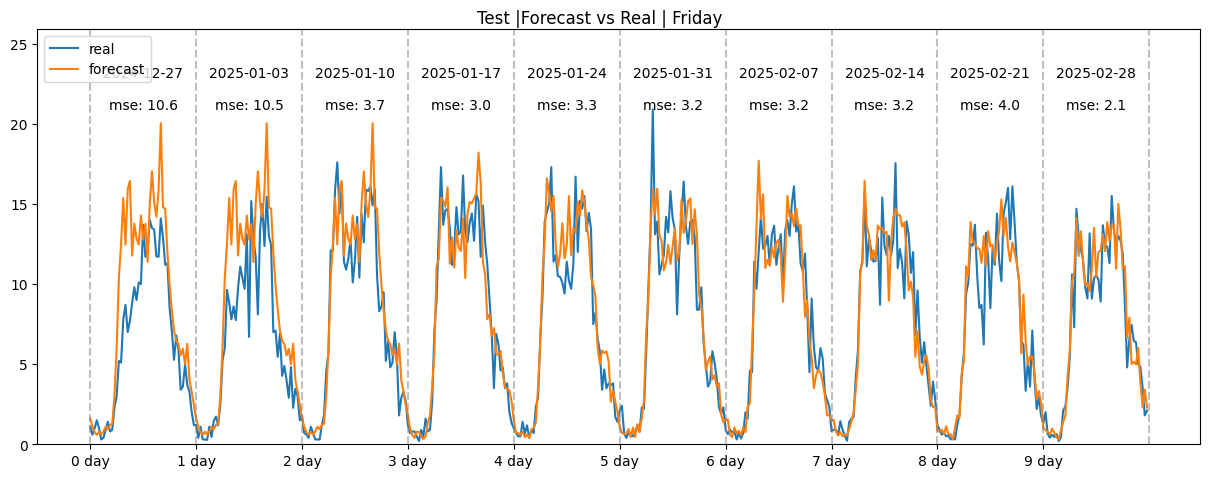

In [32]:
day=4
fig = ForecastPerWeekdayPlotter(day=day).plot(X_train, forecast_train, train_dates)
fig.suptitle(f'Train |Forecast vs Real | {days[day]}')
fig = ForecastPerWeekdayPlotter(day=day).plot(X_test, forecast_test, test_dates)
fig.suptitle(f'Test |Forecast vs Real | {days[day]}')
plt.show()

#### Saturday

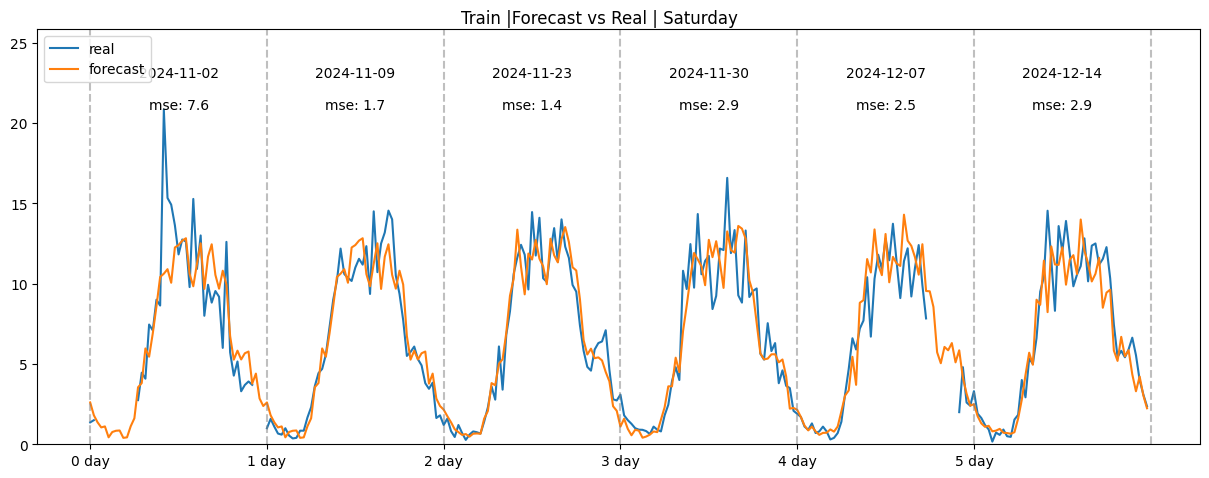

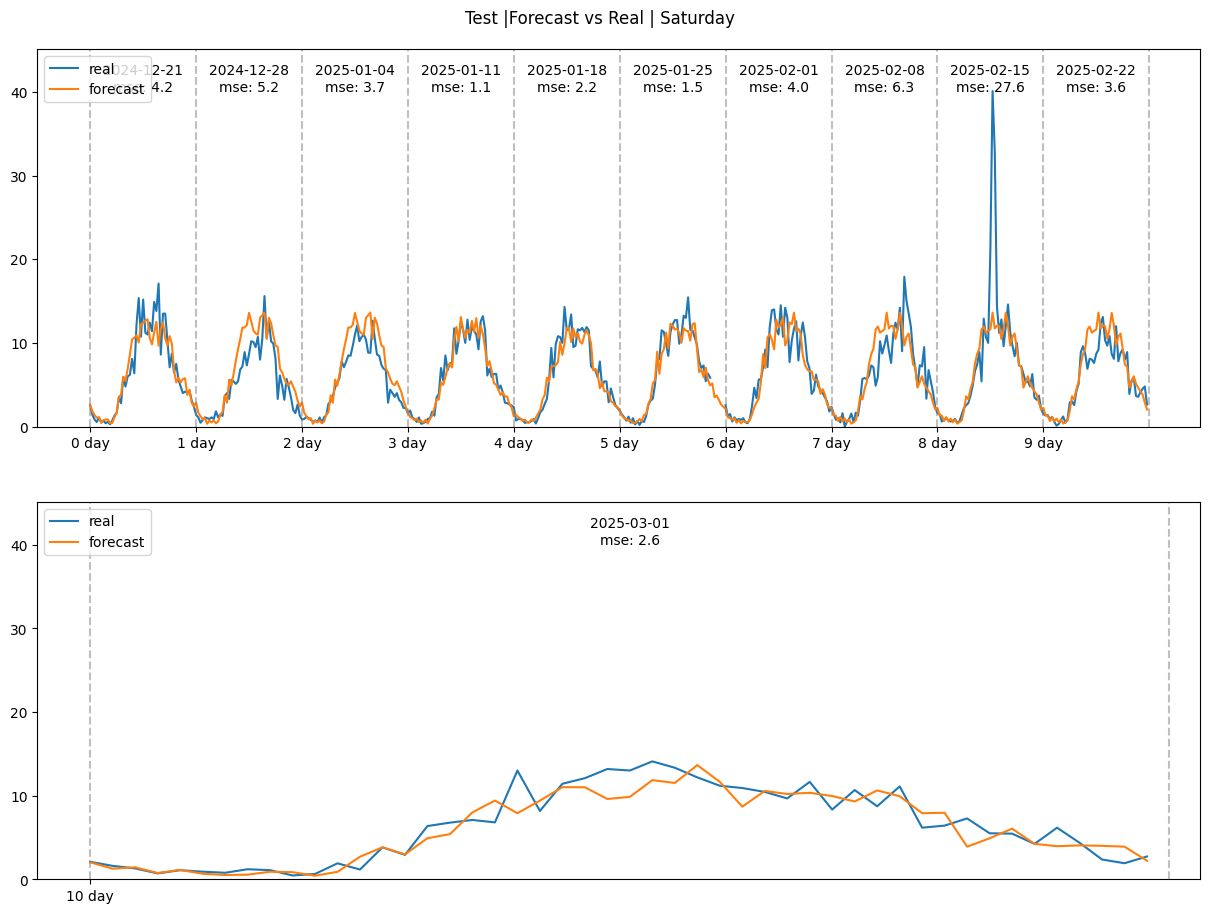

In [33]:
day=5
fig = ForecastPerWeekdayPlotter(day=day).plot(X_train, forecast_train, train_dates)
fig.suptitle(f'Train |Forecast vs Real | {days[day]}')
fig = ForecastPerWeekdayPlotter(day=day).plot(X_test, forecast_test, test_dates)
fig.suptitle(f'Test |Forecast vs Real | {days[day]}')
plt.show()

#### Sunday 

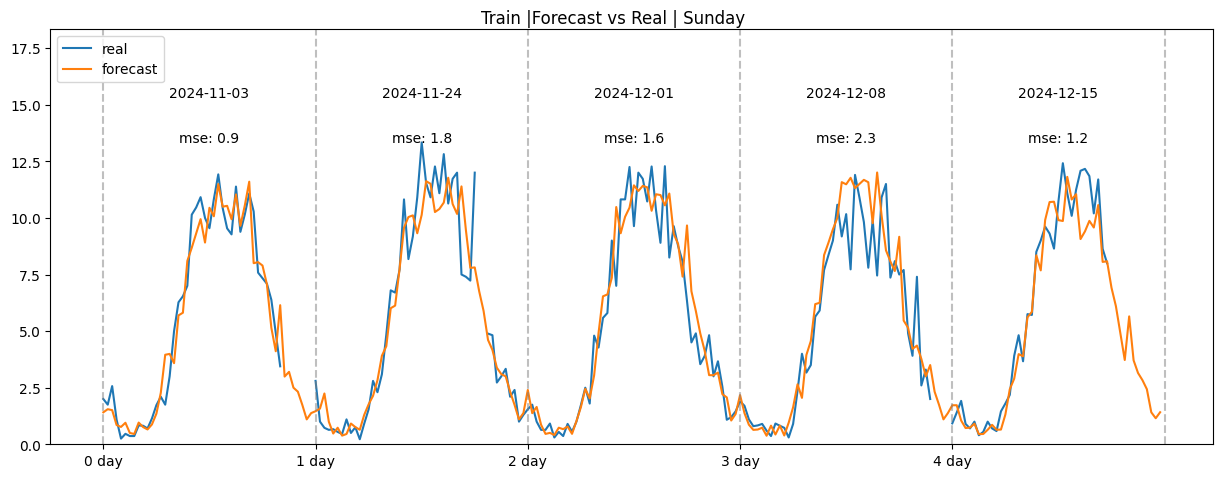

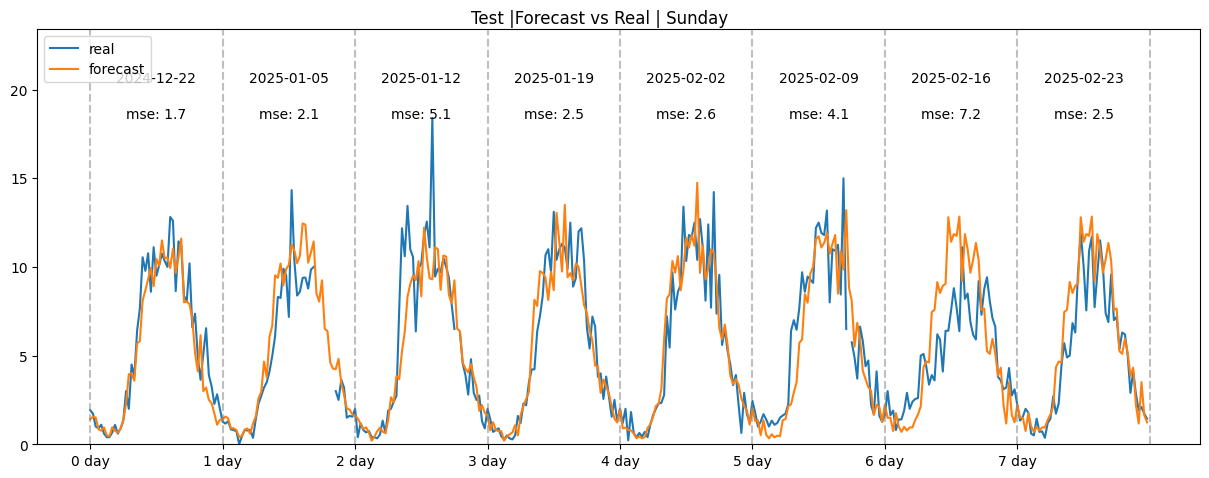

In [34]:
day=6
fig = ForecastPerWeekdayPlotter(day=day).plot(X_train, forecast_train, train_dates)
fig.suptitle(f'Train |Forecast vs Real | {days[day]}')
fig = ForecastPerWeekdayPlotter(day=day).plot(X_test, forecast_test, test_dates)
fig.suptitle(f'Test |Forecast vs Real | {days[day]}')
plt.show()

### Plots across all days

#### Train 

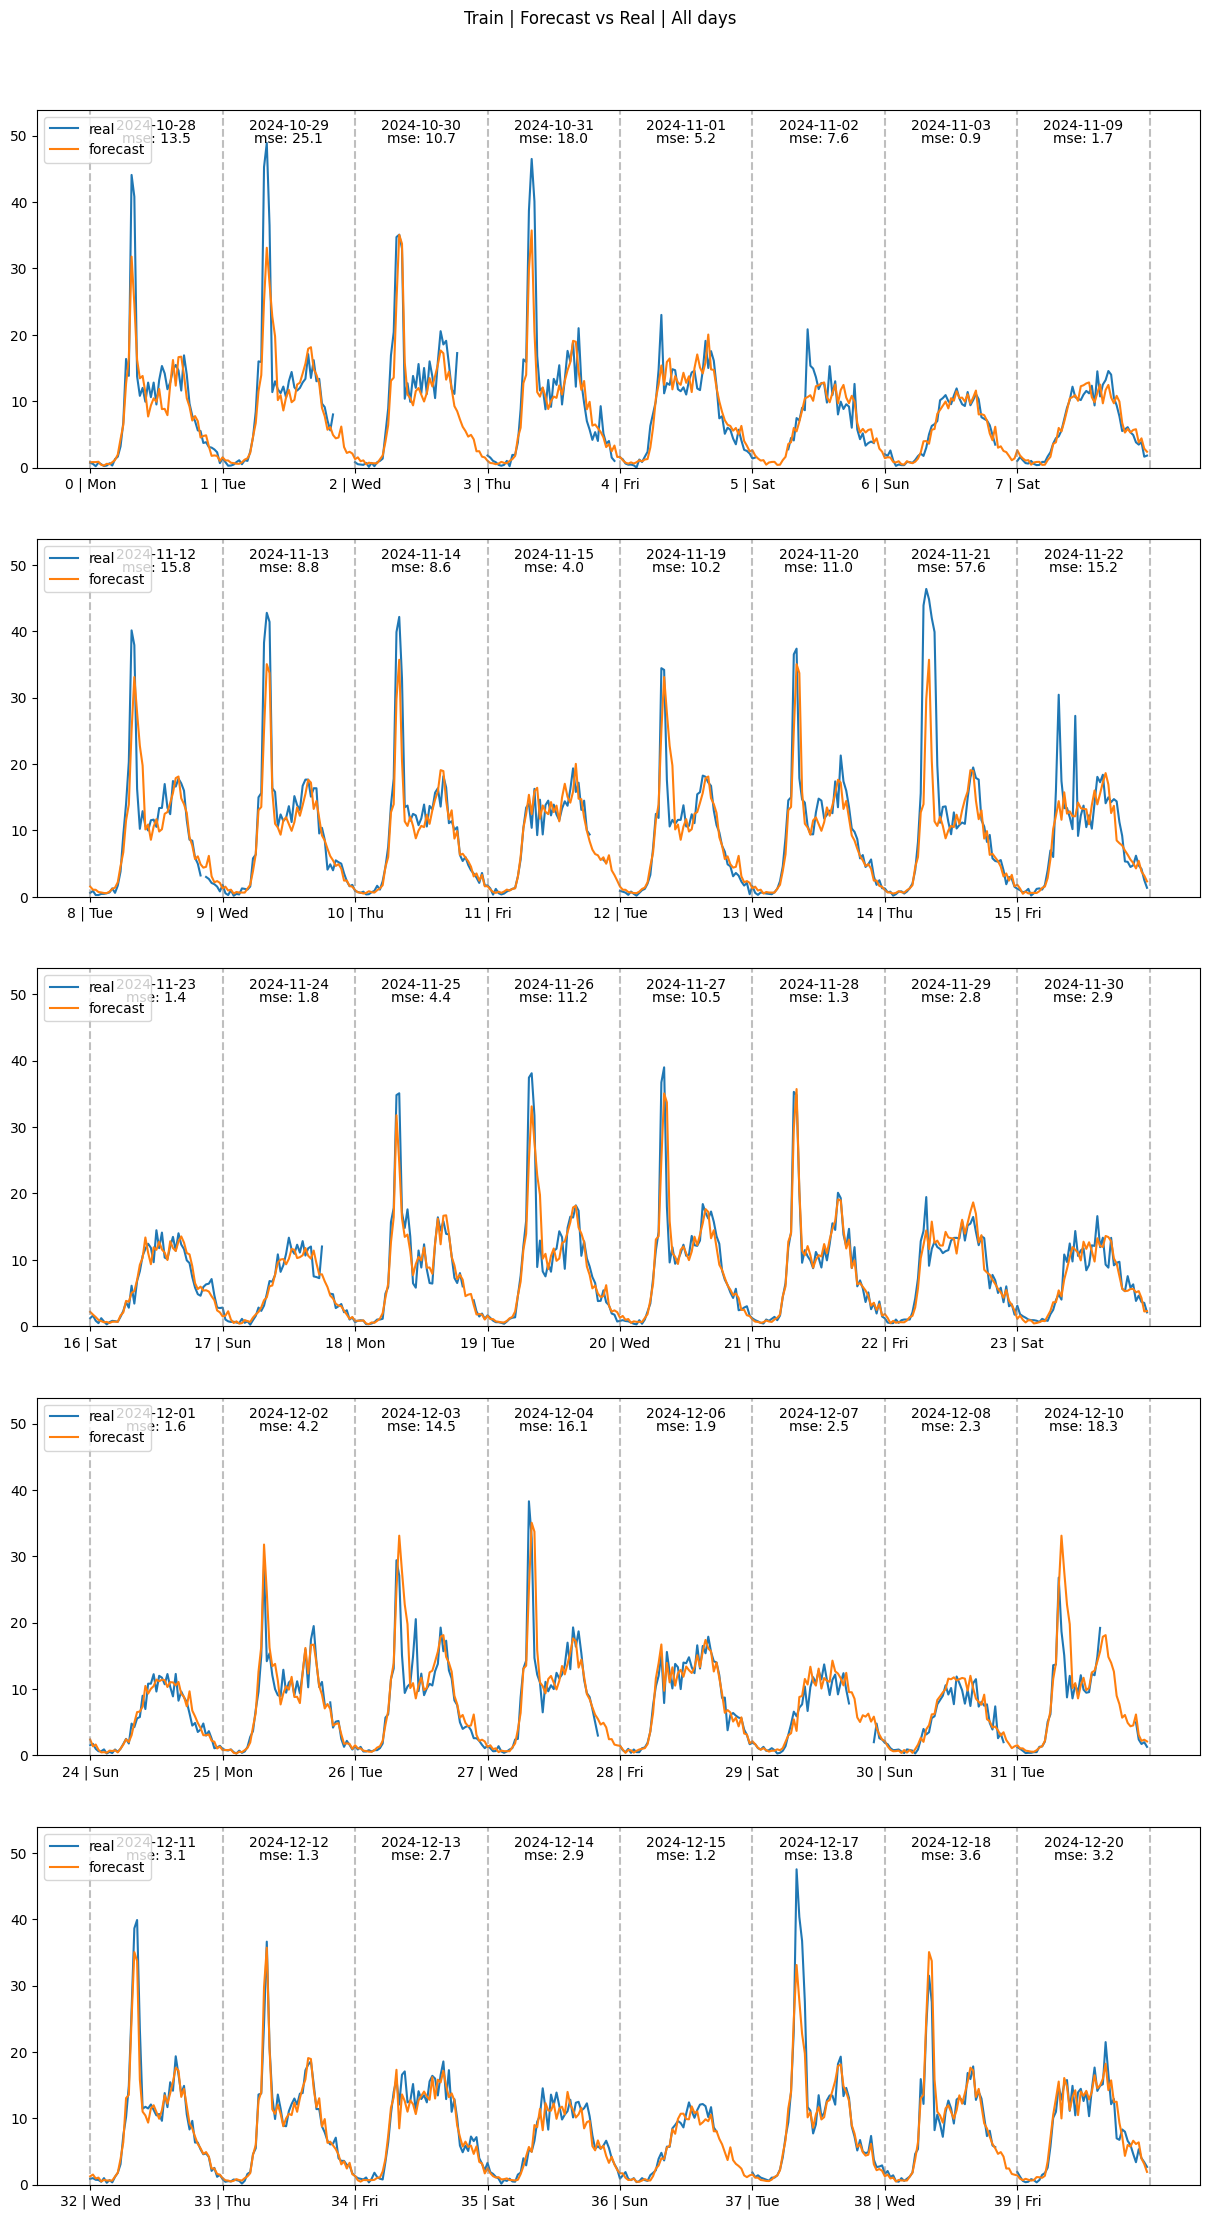

In [35]:
plot_all_day = ForecastAllDayPlotter(n_days_in_row=8)
fig = plot_all_day.plot(X_train, forecast_train, train_dates)
fig.suptitle('Train | Forecast vs Real | All days')
plt.show()

#### Test 

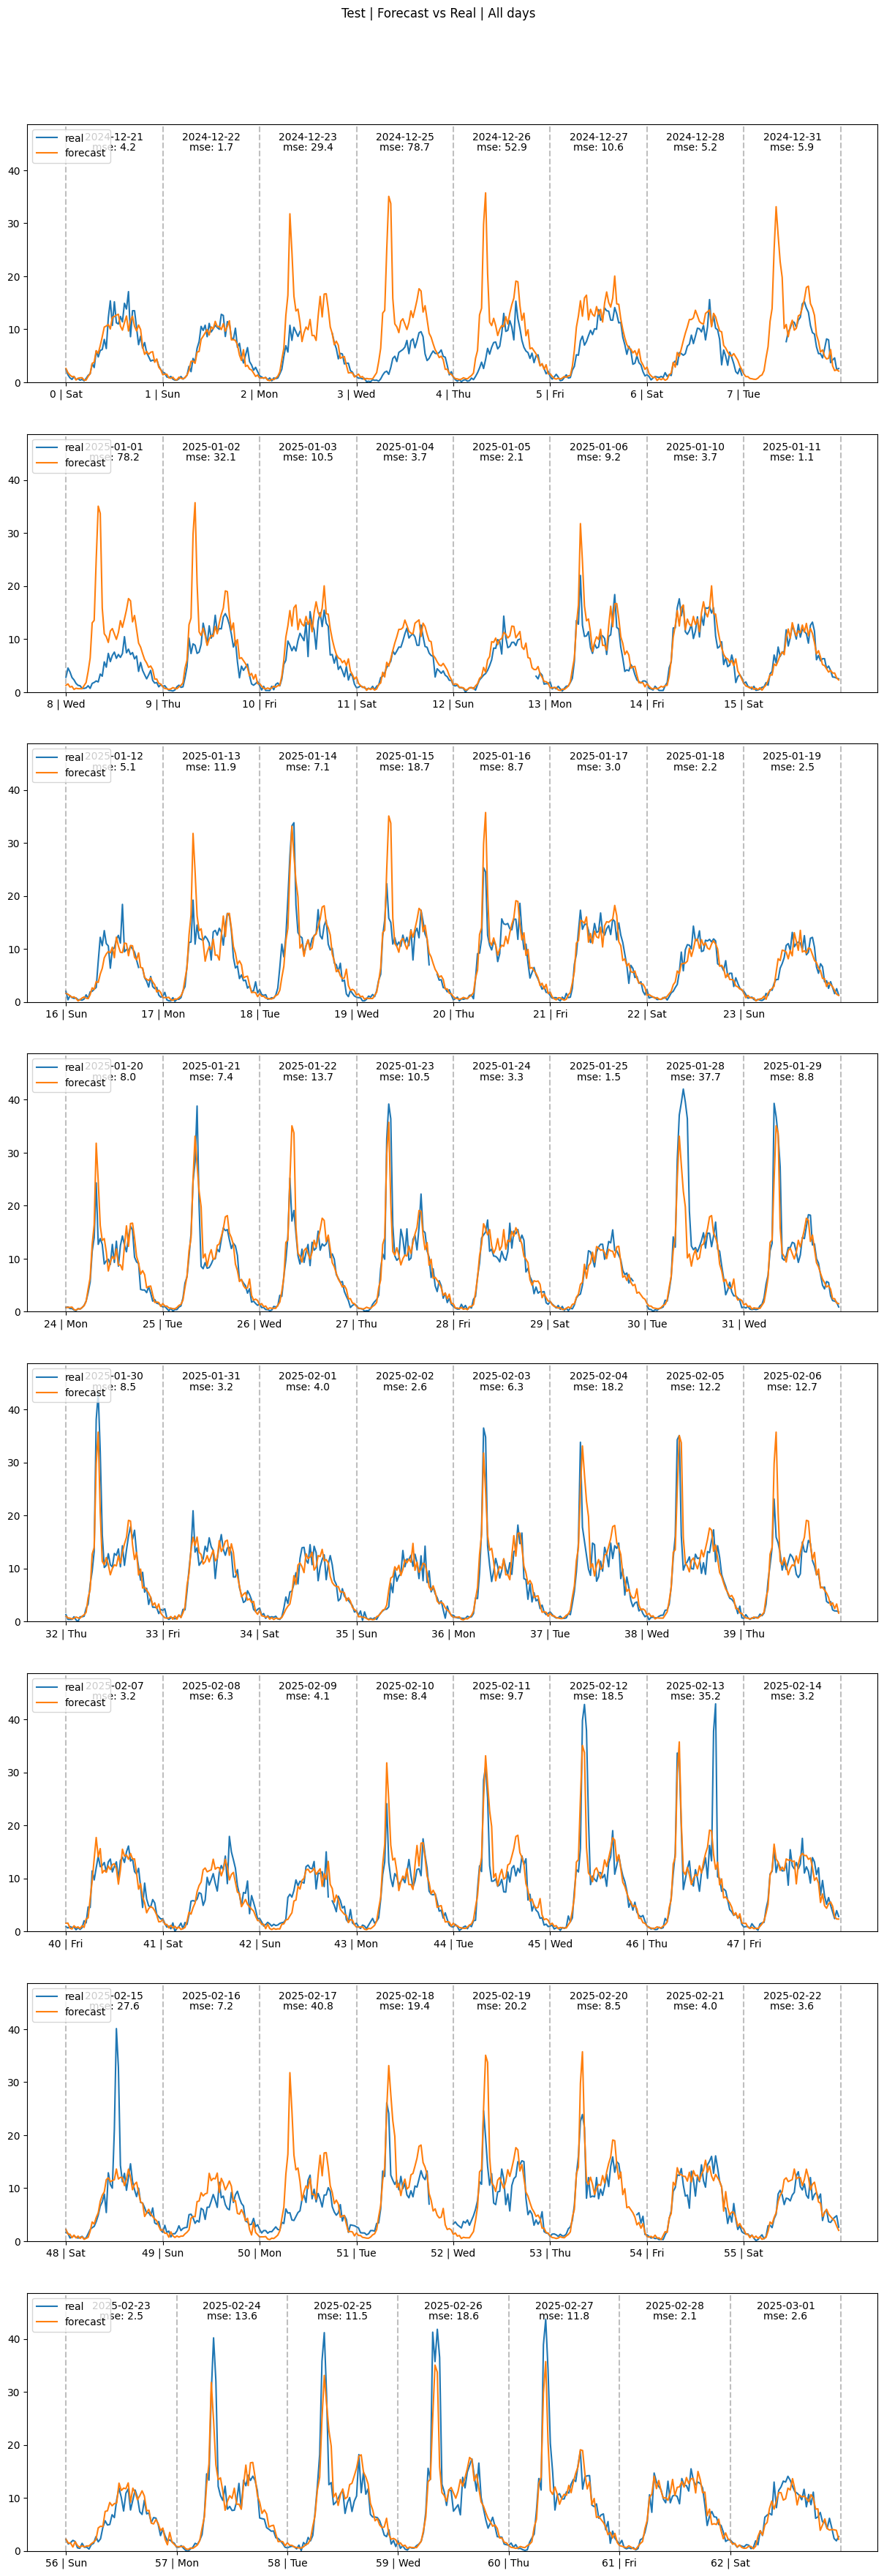

In [36]:
plot_all_day = ForecastAllDayPlotter(n_days_in_row=8)
fig = plot_all_day.plot(X_test, forecast_test, test_dates)
fig.suptitle('Test | Forecast vs Real | All days')
plt.show()

### Overall Performance

In [37]:
y_true = X_train[:,0]
mask=~np.isnan(y_true)
mse = mean_squared_error(y_true[mask], forecast_train[mask])
print(f"Train MSE: {mse:.2f}")

Train MSE: 8.58


In [38]:
y_true = X_test[:,0]
mask=~np.isnan(y_true)
mse = mean_squared_error(y_true[mask], forecast_test[mask])
print(f"Test MSE: {mse:.2f}")

Test MSE: 13.17


## Plotly Plot

In [39]:
df_plot = pd.read_csv(plot_csv_path, index_col='time')
df_plot.index = pd.to_datetime(df_plot.index)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot['num_cars'],
    mode="lines+markers",
    name="Real Data",
    opacity=0.5
))

fig.add_trace(go.Scatter(
    x=df_plot.index,
    y=df_plot['forecast'],
    mode="lines+markers",
    name="Forecast Data",
    opacity=0.5
))

# Calculate the range for the last 7 days
end_date = df_plot.index.max() + timedelta(hours=3)
start_date = end_date - timedelta(days=7)

fig.update_layout(
    title="Traffic Analysis of the William R. Bennett Bridge", 
    xaxis=dict(
        title="Date",
        type="date",  # Ensures proper date handling
        rangeslider=dict(visible=True),  # Enables scrolling
        range=[start_date, end_date]  # Set the initial range to the last 7 days
    ),
    yaxis=dict(title="Average number of cars at 30-minute intervals"),
    annotations=[
        dict(
            xref="paper",
            yref="paper",
            x=1,
            y=1,
            showarrow=False,
            text="For more details, visit <a href='https://github.com/AbdulRahmanSilmy/traffic-net'>GitHub</a>"
        )
    ]
)

fig.show()
fig.write_html(html_path)